# For ECCO
WG region

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.4:33593")
client

Client Scheduler: tcp://10.32.16.4:33593 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

In [3]:
xr.set_options(display_style='text')

# Validating Heat Budget (w zarr ds)

In [4]:
ds_wg = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_wg

<xarray.Dataset>
Dimensions:                  (i: 95, j: 50, k: 50, time: 288)
Coordinates:
  * k                        (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH     (k, time, j, i) float32 dask.array<chunksize=(50, 1, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH          (time, j, i, k) float32 dask.array<chunksize=(1, 50, 95, 50), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>

In [10]:
ds_wg.sw_flux_conv_TH

<xarray.DataArray 'sw_flux_conv_TH' (time: 288, j: 50, i: 95, k: 50)>
dask.array<zarr, shape=(288, 50, 95, 50), dtype=float32, chunksize=(1, 50, 95, 50), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

### Entire WG column budget

In [11]:
rhs_heat = ((ds_wg.conv_horiz_adv_flux_TH + 
             ds_wg.conv_horiz_diff_flux_TH + 
             ds_wg.conv_vert_adv_flux_TH +
             ds_wg.conv_vert_diff_flux_TH + 
             ds_wg.surface_flux_conv_TH + 
             ds_wg.sw_flux_conv_TH).sum(dim=['i', 'j', 'k'])).load()

lhs_heat = ds_wg.total_tendency_TH_truth.sum(dim=['i', 'j', 'k']).load()

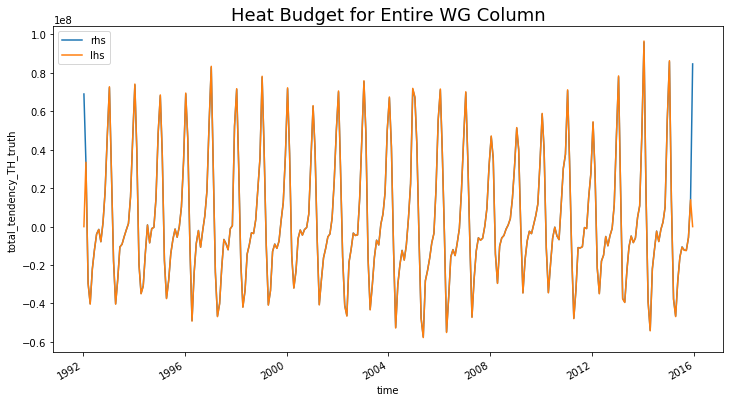

In [12]:
plt.figure(figsize=(12,6))
rhs_heat.plot(label='rhs')
lhs_heat.plot(label='lhs')
plt.legend()
plt.title('Heat Budget for Entire WG Column', fontsize=18);

Going to try adding zeros to surf-flux-term to have full depth of 50 levels since xarray could be broadcasting... - (update: didn't work)

### Interior WG column budget

In [9]:
lower_cell_range = dict(k_l=[36, 49])
lower_cell_range_z = dict(k=slice(36, 49))

In [11]:
ds_wg_lower = ds_wg.isel(**lower_cell_range_z)
ds_wg_lower

<xarray.Dataset>
Dimensions:                  (i: 95, j: 50, k: 13, time: 288)
Coordinates:
  * k                        (k) int64 36 37 38 39 40 41 42 43 44 45 46 47 48
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH     (k, time, j, i) float32 dask.array<chunksize=(13, 1, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH          (time, j, i, k) float32 dask.array<chunksize=(1, 50, 95, 13), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 95), meta=np.ndarray>

In [12]:
rhs_heat_lower = ((ds_wg_lower.conv_horiz_adv_flux_TH + 
                  ds_wg_lower.conv_horiz_diff_flux_TH + 
                  ds_wg_lower.conv_vert_adv_flux_TH +
                  ds_wg_lower.conv_vert_diff_flux_TH).sum(dim=['i', 'j', 'k'])).load()

lhs_heat_lower = ds_wg_lower.total_tendency_TH_truth.sum(dim=['i', 'j', 'k']).load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


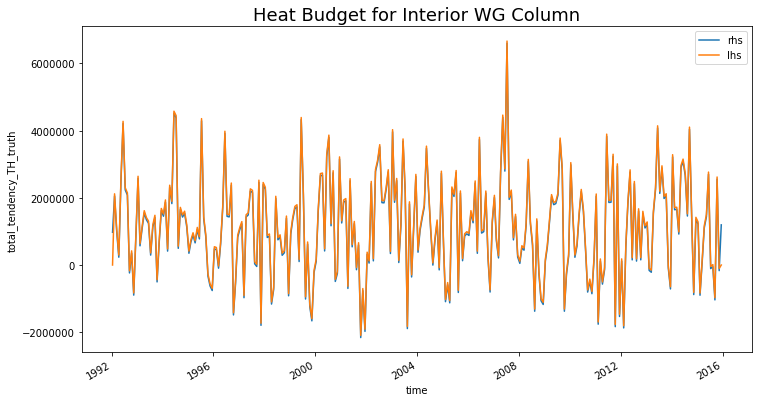

In [13]:
plt.figure(figsize=(12,6))
rhs_heat_lower.plot(label='rhs')
lhs_heat_lower.plot(label='lhs')
plt.legend()
plt.title('Heat Budget for Interior WG Column', fontsize=18);

# Validating Salt Budget (w zarr ds)

In [14]:
ds_slt_wg = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr'))
ds_slt_wg

<xarray.Dataset>
Dimensions:                   (i: 95, j: 50, k: 50, time: 288)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_SLT          (k, time, j, i) float32 dask.array<chunksize=(50, 1, 50, 95), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>

### Entire WG column budget

In [15]:
rhs_slt = ((ds_slt_wg.conv_horiz_adv_flux_SLT +
            ds_slt_wg.conv_horiz_diff_flux_SLT +
            ds_slt_wg.salt_plume).sum(dim=['i', 'j', 'k']) +
            ds_slt_wg.surface_flux_SLT.sum(dim=['i', 'j', 'k'])).load()

lhs_slt = ds_slt_wg.total_tendency_SLT_truth.sum(dim=['i', 'j', 'k']).load()

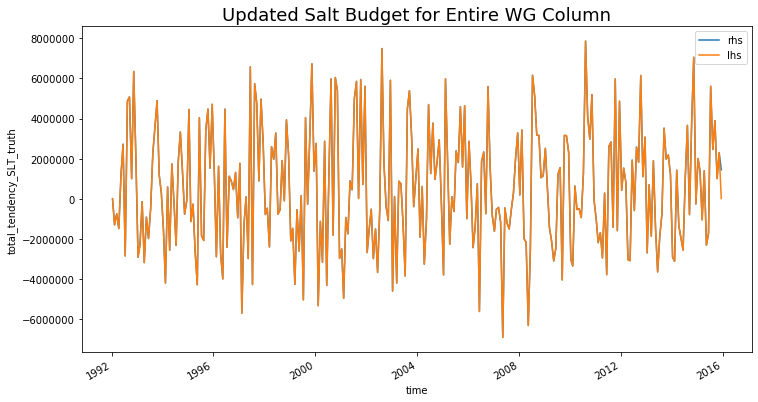

In [16]:
plt.figure(figsize=(12,6))
rhs_slt.plot(label='rhs')
lhs_slt.plot(label='lhs')
plt.legend()
plt.title('Updated Salt Budget for Entire WG Column', fontsize=18);

### Interior WG column budget

In [17]:
ds_slt_wg_lower = ds_slt_wg.isel(**lower_cell_range_z)
ds_slt_wg_lower

<xarray.Dataset>
Dimensions:                   (i: 95, j: 50, k: 13, time: 288)
Coordinates:
  * k                         (k) int64 36 37 38 39 40 41 42 43 44 45 46 47 48
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 95), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 95), meta=np.ndarray>
    surface_flux_SLT          (k, time, j, i) float32 dask.array<chunksize=(13, 1, 50, 95), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 95), meta=np.ndarray>

In [18]:
rhs_slt_lower = (ds_slt_wg_lower.conv_horiz_adv_flux_SLT +
                 ds_slt_wg_lower.conv_horiz_diff_flux_SLT +
                 ds_slt_wg_lower.conv_vert_adv_flux_SLT +
                 ds_slt_wg_lower.conv_vert_diff_flux_SLT + 
                 ds_slt_wg_lower.salt_plume).sum(dim=['i', 'j', 'k']).load()

lhs_slt_lower = ds_slt_wg_lower.total_tendency_SLT_truth.sum(dim=['i', 'j', 'k']).load()

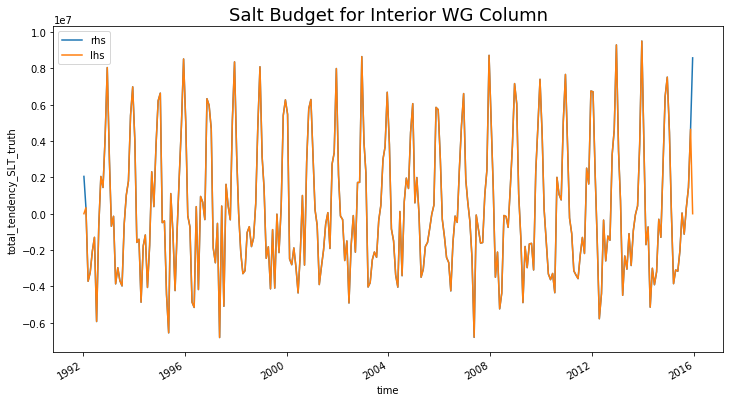

In [19]:
plt.figure(figsize=(12,6))
rhs_slt_lower.plot(label='rhs')
lhs_slt_lower.plot(label='lhs')
plt.legend()
plt.title('Salt Budget for Interior WG Column', fontsize=18);